# Reconstruction of a positive-real wavefunction

In this tutorial, a walkthrough of how to reconstruct a **positive-real** wavefunction via training a *Restricted Boltzmann Machine* (RBM), the neural network behind qucumber, will be presented. The data used for training will be $\sigma^{z}$ measurements from a one-dimensional transverse-field Ising model (TFIM) with 10 sites at its critical point.

## Transverse-field Ising model
The example dataset, located in *tfim1d_data.txt*, comprises of 10,000 $\sigma^{z}$ measurements from a one-dimensional transverse-field Ising model (TFIM) with 10 sites at its critical point. The Hamiltonian for the transverse-field Ising model (TFIM) is given by

\begin{equation}
	\mathcal{H} = -J\sum_i \sigma^z_i \sigma^z_{i+1} - h \sum_i
\sigma^x_i
\end{equation}

where $\sigma^{z}_i$ is the conventional spin-1/2 Pauli operator on site $i$. At the critical point, $J=h=1$. As per convention, spins are represented in binary notation with zero and one denoting spin-down and spin-up, respectively.

## Using qucumber to reconstruct the wavefunction

### Imports
To begin the tutorial, first import the required Python packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qucumber.nn_states import PositiveWavefunction
from qucumber.callbacks import MetricEvaluator

import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data

The Python class *PositiveWavefunction* contains generic properties of a RBM meant to reconstruct a positive-real wavefunction, the most notable one being the gradient function required for stochastic gradient descent.

To instantiate a *PositiveWavefunction* object, one needs to specify the number of visible and hidden units in the RBM. The number of visible units, *num_visible*, is given by the size of the physical system, i.e. the number of spins or qubits (10 in this case), while the number of hidden units, *num_hidden*, can be varied to change the expressiveness of the neural network.

**Note:** The optimal *num_hidden* : *num_visible* ratio will depend on the system. For the TFIM, having this ratio be equal to 1 leads to good results with reasonable computational effort.

### Training
To evaluate the training in real time, the fidelity between the true ground-state wavefunction of the system and the wavefunction that qucumber reconstructs, $\vert\langle\psi\vert\psi_{RBM}\rangle\vert^2$, will be calculated along with the Kullback-Leibler (KL) divergence (the RBM's cost function). It will also be shown that any custom function can be used to evaluate the training.

First, the training data and the true wavefunction of this system must be loaded using the *data* utility.

In [2]:
psi_path = "tfim1d_psi.txt"
train_path = "tfim1d_data.txt"
train_data, true_psi = data.load_data(train_path, psi_path)

As previously mentioned, to instantiate a *PositiveWavefunction* object, one needs to specify the number of visible and hidden units in the RBM. These two quantities equal will be kept equal.

In [3]:
nv = train_data.shape[-1]
nh = nv

nn_state = PositiveWavefunction(num_visible=nv, num_hidden=nh)
# nn_state = PositiveWavefunction(num_visible=nv, num_hidden=nh, gpu = False)

By default, qucumber will attempt to run on a GPU if one is available (if one is not available, qucumber will default to CPU). If one wishes to run qucumber on a CPU, add the flag "gpu = False" in the *PositiveWavefunction* object instantiation (i.e. uncomment the line above). 

Now the hyperparameters of the training process can be specified.

1. **epochs**: the total number of training cycles that will be performed (default = 100)
2. **pos_batch_size**: the number of data points used in the positive phase of the gradient (default = 100)
3. **neg_batch_size**: the number of data points used in the negative phase of the gradient (default = *pos_batch_size*)
4. **k**: the number of contrastive divergence steps (default = 1)
5. **lr**: the learning rate (default = 0.001)

    **Note:** For more information on the hyperparameters above, it is strongly encouraged that the user to read through the brief, but thorough theory document on RBMs located in the qucumber documentation. One does not have to specify these hyperparameters, as their default values will be used without the user overwriting them. It is recommended to keep with the default values until the user has a stronger grasp on what these hyperparameters mean. The quality and the computational efficiency of the training will highly depend on the choice of hyperparameters. As such, playing around with the hyperparameters is almost always necessary. 
    
For the TFIM with 10 sites, the following hyperparameters give excellent results.

In [4]:
epochs = 1000
pbs = 100  # pos_batch_size
nbs = 200  # neg_batch_size
lr = 0.01
k = 10

For evaluating the training in real time, the *MetricEvaluator* will be called in order to calculate the training evaluators every 100 epochs. The *MetricEvaluator* requires the following arguments.

1. **log_every**: the frequency of the training evaluators being calculated is controlled by the *log_every* argument (e.g. *log_every* = 200 means that the *MetricEvaluator* will update the user every 200 epochs)
2. A dictionary of functions you would like to reference to evaluate the training (arguments required for these functions are keyword arguments placed after the dictionary)

The following additional arguments are needed to calculate the fidelity and KL divergence in the *training_statistics* utility.

- **target_psi**: the true wavefunction of the system
- **space**: the hilbert space of the system

The training evaluators can be printed out via the *verbose=True* statement.

Although the fidelity and KL divergence are excellent training evaluators, they are not practical to calculate in most cases; the user may not have access to the target wavefunction of the system, nor may generating the hilbert space of the system be computationally feasible. However, evaluating the training in real time is extremely convenient. 

Any custom function that the user would like to use to evaluate the training can be given to the *MetricEvaluator*, thus avoiding having to calculate fidelity and/or KL divergence. Any custom function given to *MetricEvaluator* must take the neural-network state (in this case, the *PositiveWavefunction* object) and keyword arguments. As an example, the function to be passed to the *MetricEvaluator* will be the fifth coefficient of the reconstructed wavefunction multiplied by a parameter, *A*.

In [5]:
def psi_coefficient(nn_state, space, A, **kwargs):
    norm = nn_state.compute_normalization(space).sqrt_()
    return A * nn_state.psi(space)[0][4] / norm

Now the hilbert space of the system can be generated for the fidelity and KL divergence and the dictionary of functions the user would like to compute every "*log_every*" epochs can be given to the *MetricEvaluator*.

In [6]:
log_every = 100
space = nn_state.generate_hilbert_space(nv)

Now the training can begin. The *PositiveWavefunction* object has a property called *fit* which takes care of this. *MetricEvaluator* must be passed to the *fit* function in a list (*callbacks*).

In [7]:
callbacks = [
    MetricEvaluator(
        log_every,
        {"Fidelity": ts.fidelity, "KL": ts.KL, "A_Ψrbm_5": psi_coefficient},
        target_psi=true_psi,
        verbose=True,
        space=space,
        A=3.,
    )
]

nn_state.fit(
    train_data,
    epochs=epochs,
    pos_batch_size=pbs,
    neg_batch_size=nbs,
    lr=lr,
    k=k,
    callbacks=callbacks,
)
# nn_state.fit(train_data, callbacks=callbacks)

Epoch: 100	Fidelity = 0.916228	KL = 0.171583	A_Ψrbm_5 = 0.222936
Epoch: 200	Fidelity = 0.964221	KL = 0.071276	A_Ψrbm_5 = 0.210849
Epoch: 300	Fidelity = 0.979963	KL = 0.039937	A_Ψrbm_5 = 0.221388
Epoch: 400	Fidelity = 0.987497	KL = 0.024977	A_Ψrbm_5 = 0.223976
Epoch: 500	Fidelity = 0.989811	KL = 0.020543	A_Ψrbm_5 = 0.235250
Epoch: 600	Fidelity = 0.991764	KL = 0.016631	A_Ψrbm_5 = 0.232943
Epoch: 700	Fidelity = 0.993143	KL = 0.013830	A_Ψrbm_5 = 0.234583
Epoch: 800	Fidelity = 0.993379	KL = 0.013242	A_Ψrbm_5 = 0.241191
Epoch: 900	Fidelity = 0.994647	KL = 0.010728	A_Ψrbm_5 = 0.237508
Epoch: 1000	Fidelity = 0.995182	KL = 0.009666	A_Ψrbm_5 = 0.238725


All of these training evaluators can be accessed after the training has completed, as well. The code below shows this, along with plots of each training evaluator versus the training cycle number (epoch).

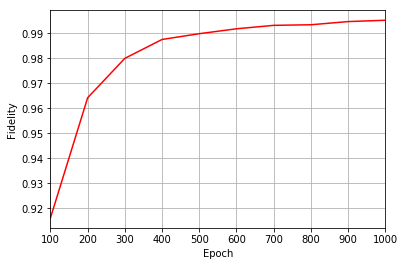

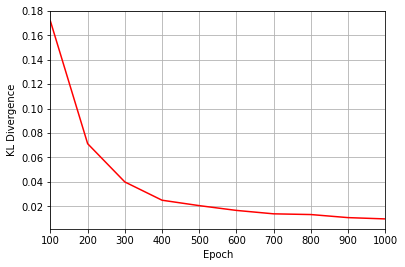

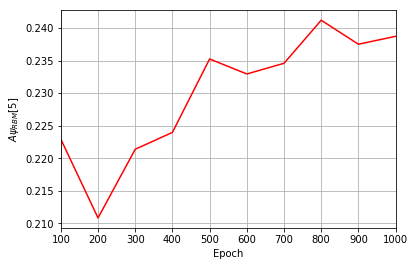

In [8]:
fidelities = callbacks[0].Fidelity
KLs = callbacks[0].KL
coeffs = callbacks[0].A_Ψrbm_5
# Please note that the key given to the *MetricEvaluator* must be what comes after callbacks[0].
epoch = np.arange(log_every, epochs + 1, log_every)

plt.figure(1)
ax1 = plt.axes()
ax1.grid()
ax1.set_xlim(log_every, epochs)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Fidelity")
ax1.plot(epoch, fidelities, color="r")

plt.figure(2)
ax2 = plt.axes()
ax2.grid()
ax2.set_xlim(log_every, epochs)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("KL Divergence")
ax2.plot(epoch, KLs, color="r")

plt.figure(3)
ax3 = plt.axes()
ax3.grid()
ax3.set_xlim(log_every, epochs)
ax3.set_xlabel("Epoch")
ax3.set_ylabel(r"$A\psi_{RBM}[5]$")
ax3.plot(epoch, coeffs, color="r")

It should be noted that one could have just ran *nn_state.fit(train_samples)* and just used the default hyperparameters and no training evaluators.

To demonstrate how important it is to find the optimal hyperparameters for a certain system, restart this notebook and comment out the original *fit* statement and uncomment the one below. The default hyperparameters will be used instead. Using the non-default hyperparameters yielded a fidelity of approximately 0.994, while the default hyperparameters yielded a fidelity of approximately 0.523!

The RBM's parameters will also be saved for future use in other tutorials. They can be saved to a pickle file with the name "saved_params.pt" with the code below.

In [9]:
nn_state.save("saved_params.pt")

This saves the weights, visible biases and hidden biases as torch tensors with the following keys: "weights", "visible_bias", "hidden_bias".